<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "PAL-Inh"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/Level3-SubCellType/PAL-Inh/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


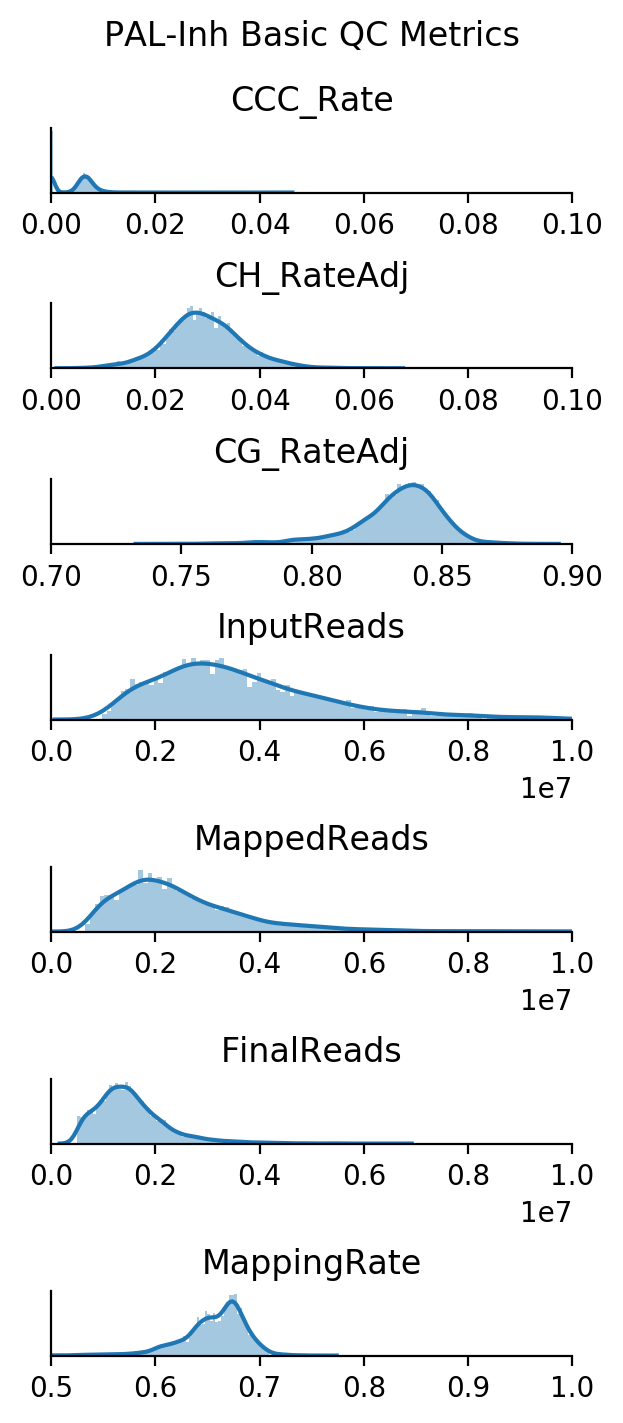

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

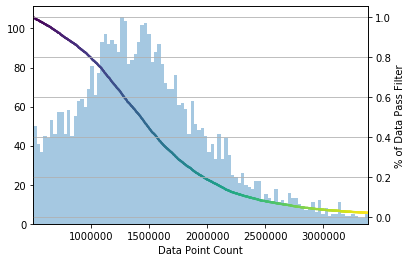

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 4481/4481 (100.0%)
CG_RateAdj passed 4481/4481 (100.0%)
CH_RateAdj passed 4481/4481 (100.0%)
FinalReads passed 4481/4481 (100.0%)
MappingRate passed 4481/4481 (100.0%)
Overall passed 4481/4481 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
171206 1
171212 2
171213 1
171214 23
171219 34
180104 3
180109 42
180110 145
180111 67
180130 1
180205 1
180206 1
180208 60
180212 38
180213 1
180220 53
180222 64
180226 1
180313 24
180319 10
180320 50
180326 36
180329 53
180402 56
180403 61
180405 75
180412 1
180416 2
180501 1
180529 2
180724 111
180806 340
180911 649
180917 120
180925 52
181002 1
181008 39
181009 34
181015 793
181016 579
181022 1
181204 99
181206 32
181210 1
181218 107
181220 169
190124 1
190131 53
190205 67
190207 290
190212 5
190214 4
190219 1
190305 2
190307 2
190625 2
190627 4
190711 2
190716 12


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 553 144.0%
ad002 536 139.6%
ad004 597 155.5%
ad006 535 139.3%
ad007 583 151.8%
ad008 570 148.4%
ad010 552 143.8%
ad012 555 144.5%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l1-umap_0,l1-umap_1,l1-tsne_0,l1-tsne_1,MajorType,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,PassFilter
cell,,,,,,,,,,,,,,,,,,,,,
10E_M_1731,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.009285,0.849906,0.848500,0.047471,0.038544,929549.0,3352936,2016767.0,10E,...,7.269006,8.514217,-4.657740,25.101182,PAL-Inh,-9.756730,1.847366,-19.192965,8.712636,True
10E_M_2273,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.008020,0.819869,0.818412,0.041127,0.033374,1864590.0,5940840,3788250.0,10E,...,7.043445,3.011953,-11.675975,18.719322,PAL-Inh,-7.960672,-0.192429,-6.870722,16.876104,True
10E_M_2723,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.008002,0.825311,0.823901,0.040573,0.032833,1769252.0,5564812,3424041.0,10E,...,7.570697,2.607040,-13.028148,21.775658,PAL-Inh,-7.569923,-0.279395,-6.531026,16.936358,True
10F_M_2923,/gale/raidix/rdx-4/mapping/10F/CEMBA190627-10F...,0.004616,0.755099,0.753963,0.010240,0.005650,560459.0,1680988,1035942.0,10F,...,9.356696,2.884705,-29.632851,21.132935,PAL-Inh,-8.871187,1.844872,-17.249041,10.848939,True
10F_M_676,/gale/raidix/rdx-4/mapping/10F/CEMBA190625-10F...,0.008434,0.824442,0.822949,0.045896,0.037781,1588945.0,4149822,2752787.0,10F,...,7.891718,3.766357,-11.479751,21.365136,PAL-Inh,-7.223098,-1.138751,-0.359571,20.178134,True
10F_M_805,/gale/raidix/rdx-4/mapping/10F/CEMBA190625-10F...,0.006835,0.799628,0.798249,0.032067,0.025406,1389933.0,3529368,2370028.0,10F,...,6.757225,2.749668,-11.483438,16.662867,PAL-Inh,-7.516029,-0.597752,-9.751972,17.209231,True
11E_M_155,/gale/raidix/rdx-4/mapping/11E/CEMBA190214-11E...,0.006621,0.831340,0.830216,0.030025,0.023561,778292.0,2372378,1380256.0,11E,...,7.243410,8.534295,-4.834983,25.232931,PAL-Inh,-10.211645,1.756524,-19.487355,8.436303,True
11E_M_1666,/gale/raidix/rdx-4/mapping/11E/CEMBA190305-11E...,0.008371,0.843290,0.841967,0.040088,0.031985,659367.0,1535206,1057001.0,11E,...,7.253940,8.430206,-4.734330,25.340835,PAL-Inh,-9.803421,1.723080,-19.291729,8.575405,True
11E_M_352,/gale/raidix/rdx-4/mapping/11E/CEMBA190214-11E...,0.007486,0.823031,0.821696,0.035191,0.027913,559346.0,1451548,913052.0,11E,...,6.991779,9.434650,-4.525835,25.537944,PAL-Inh,-9.622242,1.926494,-18.623501,9.462283,True
